Project: Loan DNN

- Author: Casey Kellett Whitwham
- Goal: 92%
- Final result: 92.00164079666138%

------------------------------------------------------------------------------------

Imports

------------------------------------------------------------------------------------

In [1]:
import importlib

import dataprep as dp
importlib.reload(dp)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras_tuner as kt

------------------------------------------------------------------------------------

Load Prepped Data

------------------------------------------------------------------------------------

In [2]:
Xtrain,ytrain,Xtest,ytest,Xdev,ydev = dp.loadprocesseddata()

(24384, 12)


c:\Users\casey\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\casey\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Train X,y shape:  (14609, 84) (14609,)
Test X,y shape:  (4876, 84) (4876,)
Dev X,y shape:  (4878, 84) (4878,)


---

Obtain Param Range function

---

In [3]:
##This take the top n amount of trials (n=num_to_extract) and extracts all params, putting them in a list for each param.
##We then take the min and max value for each (numerical) param.

def obtain_params(num_to_extract, search):
    top_params = []
    print(f"Number of trials to extract: {num_to_extract}")
    
    best_trials = search.oracle.get_best_trials(num_to_extract)

    for trial in best_trials:
        hyperparameters = trial.hyperparameters
        top_params.append([hyperparameters.values])

    aggregated_params = {}

    for model in top_params:
        params = model[0]

        for param, value in params.items():
            if param not in aggregated_params:
                aggregated_params[param] = []
            aggregated_params[param].append(value)

    final_results = {}
    for param, values in aggregated_params.items():
        if isinstance(values[0], (int, float)):
            final_results[param] = {
                'min': min(values),
                'max': max(values)
            }
        else:
            final_results[param] = list(set(values))

    return final_results


---

Refine Params Function

---

In [4]:
def refine_params(results, n_layers_steps, n_neurons_steps, decay_steps_steps, decay_rate_steps, dropout_rate_steps):

    n_layers_steps_updated = max(int(n_layers_steps / 2), 1)
    n_neurons_steps_updated = max(int(n_neurons_steps / 2), 1)
    decay_steps_steps_updated = max(int(decay_steps_steps / 1.25), 1)
    decay_rate_steps_updated = max(decay_rate_steps / 1.25, 0.0001)
    dropout_rate_steps_updated = max(dropout_rate_steps / 1.25, 0.0001)
    


    n_layers_range_updated = [results['n_layers']['min'], results['n_layers']['max'], n_layers_steps_updated]
    n_neurons_range_updated = [results['n_neurons']['min'], results['n_neurons']['max'], n_neurons_steps_updated]
    learning_rate_range_updated = [results['learning_rate']['min'], results['learning_rate']['max']]
    decay_steps_range_updated = [results['decay_steps']['min'], results['decay_steps']['max'], decay_steps_steps_updated]
    decay_rate_range_updated = [results['decay_rate']['min'], results['decay_rate']['max'], decay_rate_steps_updated]
    dropout_rate_range_updated = [results['dropout_rate']['min'], results['dropout_rate']['max'], dropout_rate_steps_updated]
    batch_norm_choices = results.get('batch_norm', [])
    optimizer_choices_updated = results.get('optimizer', [])
    activation_choices_updated = results.get('activation', [])
    
    return n_layers_range_updated, n_neurons_range_updated, learning_rate_range_updated, decay_steps_range_updated, decay_rate_range_updated, dropout_rate_range_updated, optimizer_choices_updated, activation_choices_updated

------------------------------------------------------------------------------------

Adaptive Build Model Function

------------------------------------------------------------------------------------

In [5]:
def build_model_adapt(hp, n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices):

    n_layers = hp.Int("n_layers", min_value=n_layers_range[0], max_value=n_layers_range[1], step=n_layers_range[2])
    n_neurons = hp.Int("n_neurons", min_value=n_neurons_range[0], max_value=n_neurons_range[1], step=n_neurons_range[2])
    learning_rate = hp.Float("learning_rate", min_value=learning_rate_range[0], max_value=learning_rate_range[1], sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=decay_steps_range[0], max_value=decay_steps_range[1], step=decay_steps_range[2])
    decay_rate = hp.Float("decay_rate", min_value=decay_rate_range[0], max_value=decay_rate_range[1], step=decay_rate_range[2])
    dropout_rate = hp.Float("dropout_rate", min_value=dropout_rate_range[0], max_value=dropout_rate_range[1], step=dropout_rate_range[2])
    batch_norm = hp.Choice("batch_norm", values=batch_norm_choices)
    
    optimizer_choice = hp.Choice("optimizer", values=optimizer_choices)

    expon_dec = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    if optimizer_choice == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=expon_dec)
    elif optimizer_choice == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=expon_dec)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=expon_dec)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(
            units=n_neurons,
            activation=hp.Choice("activation", values=activation_choices) 
        ))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="BinaryCrossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model


---

Adaptive random search

---

In [6]:
def search(i,n_layers_range,n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices,Xtrain, ytrain,Xdev, ydev):
    iteration_number = i+1
    out_folder = "Casey_DNN"
    hyp_search_folder = f"Search #{str(iteration_number)}"
    max_trials = 500
    random_search = kt.RandomSearch(
        lambda hp: build_model_adapt(hp, 
            n_layers_range, 
            n_neurons_range, 
            learning_rate_range, 
            decay_steps_range, 
            decay_rate_range, 
            dropout_rate_range, 
            optimizer_choices,
            activation_choices,
            batch_norm_choices
        ),
        objective='val_accuracy',
        max_trials=max_trials,
        directory=out_folder,
        project_name=hyp_search_folder,
        seed=42
    )
    top_perc = int((max_trials * (0.15))/iteration_number)

    print(iteration_number,top_perc)
    random_search.search(Xtrain, ytrain, epochs=5, validation_data=(Xdev, ydev))

    results = obtain_params(top_perc, random_search)
    print("Old Params :",n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices)
    n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices =refine_params(results, n_layers_range[2], n_neurons_range[2], decay_steps_range[2], decay_rate_range[2], dropout_rate_range[2])
    print("New Params :",n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices)
    return n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices                                     

---

Function to iterate random search

---

In [7]:
def iter_random(count,n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices):
    params_at_iter = []
    for i in range(0,count):
        params_at_iter.append([f"Params #{i+1}",n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices])
        print("Starting search #",i+1)
        print("Current Params: ",n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices)
        params_at_iter[i]=[n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices]
        n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices = search(i,n_layers_range,n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices,Xtrain, ytrain,Xdev, ydev)
    ranges = [n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices]
    return ranges,params_at_iter

---

Define initial param searches

---



In [8]:
n_layers_steps = 1
n_neurons_steps = 50
decay_steps_steps = 50
decay_rate_steps = 0.1
dropout_rate_steps = 0.1

n_layers_range =[2,10,n_layers_steps]
n_neurons_range =[50,750,n_neurons_steps]
learning_rate_range =[1e-8,1e-1]
decay_steps_range =[100,10000,decay_steps_steps]
decay_rate_range =[0.0001,1,decay_rate_steps]
dropout_rate_range =[0.1,0.5,dropout_rate_steps]
optimizer_choices = ["RMSprop", "adam","sgd"]
activation_choices = ["relu", "tanh", "selu", "leaky_relu"]
batch_norm_choices = [True,False]

---

Perform 3 random searches with 250 trials, extracting the range of params from the top trials 
 - Range to be extracted is based on ```int((max_trials * 0.15) / iteration_number)```,
 <br>
 - Trial 1 - top 62 trials
 - Trial 2 - top 31 trials
 - Trial 3 - top 20  trials

Then passing those values to the next iteration of random search

---

In [9]:
ranges,params_at_iter = iter_random(3,n_layers_range, n_neurons_range, learning_rate_range, decay_steps_range, decay_rate_range, dropout_rate_range, optimizer_choices,activation_choices,batch_norm_choices)
print(params_at_iter)


Starting search # 1
Current Params:  [2, 10, 1] [50, 750, 50] [1e-08, 0.1] [100, 10000, 50] [0.0001, 1, 0.1] [0.1, 0.5, 0.1] ['RMSprop', 'adam', 'sgd'] ['relu', 'tanh', 'selu', 'leaky_relu'] [True, False]
Reloading Tuner from Casey_DNN\Search #1\tuner0.json
1 75
Number of trials to extract: 75
Old Params : [2, 10, 1] [50, 750, 50] [1e-08, 0.1] [100, 10000, 50] [0.0001, 1, 0.1] [0.1, 0.5, 0.1] ['RMSprop', 'adam', 'sgd'] ['relu', 'tanh', 'selu', 'leaky_relu']
New Params : [2, 10, 1] [50, 750, 25] [2.1353405450719975e-05, 0.08809330357705886] [150, 9950, 40] [0.0001, 0.9001, 0.08] [0.1, 0.5, 0.08] ['adam', 'sgd', 'RMSprop'] ['relu', 'tanh', 'selu', 'leaky_relu']
Starting search # 2
Current Params:  [2, 10, 1] [50, 750, 25] [2.1353405450719975e-05, 0.08809330357705886] [150, 9950, 40] [0.0001, 0.9001, 0.08] [0.1, 0.5, 0.08] ['adam', 'sgd', 'RMSprop'] ['relu', 'tanh', 'selu', 'leaky_relu'] [True, False]
Reloading Tuner from Casey_DNN\Search #2\tuner0.json
2 37
Number of trials to extract: 3

---

Final Hyperband Search with refined params


In [10]:
out_folder = "Casey_DNN"
hyp_search_folder = "hyperband_search"
batch_sizes = [64, 128, 256, 512, 1024, 2048, 4096]


hyperband = kt.Hyperband(
    lambda hp: build_model_adapt(hp, 
        ranges[0], 
        ranges[1], 
        ranges[2], 
        ranges[3], 
        ranges[4], 
        ranges[5], 
        ranges[6],
        ranges[7],
        ranges[8]),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    hyperband_iterations=3,
    directory=out_folder,
    project_name=hyp_search_folder,
    seed=42
)


hyperband.search(Xtrain, ytrain, epochs=10, validation_data=(Xdev, ydev))

best_model = hyperband.get_best_models(num_models=1)[0]

for batch_size in batch_sizes:
    print(f"Evaluating batch size {batch_size}")
    loss, mape = best_model.evaluate(Xdev, ydev, batch_size=batch_size)


Reloading Tuner from Casey_DNN\hyperband_search\tuner0.json



c:\Users\casey\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 17 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluating batch size 64
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9158 - loss: 0.2469
Evaluating batch size 128
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.2452
Evaluating batch size 256
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9178 - loss: 0.2431
Evaluating batch size 512
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9185 - loss: 0.2411
Evaluating batch size 1024
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9183 - loss: 0.2426
Evaluating batch size 2048
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9196 - loss: 0.2402
Evaluating batch size 4096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9201 - loss: 0.2387


---

Display top Params

---

In [20]:
best_trial = hyperband.oracle.get_best_trials()[0]
best_hyperparameters = best_trial.hyperparameters
hyperparameter_values = best_hyperparameters.values

print("Best Hyperparameters:")
for param, value in hyperparameter_values.items():
    print(f"{param}: {value}")


Best Hyperparameters:
n_layers: 3
n_neurons: 644
learning_rate: 0.000540839799142703
decay_steps: 5217
decay_rate: 0.10250000000000001
dropout_rate: 0.1512
batch_norm: 0
optimizer: adam
activation: relu
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0045


---

Fit Best Model and plot learning curve

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, baseline=0.92)

best_model.build(input_shape = (None,84))
best_model.summary()
history = best_model.fit(Xtrain, ytrain, epochs=200, batch_size = 4096,
                               validation_data=(Xdev, ydev),callbacks=[stop_early])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 644)            │        54,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 644)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 644)            │       415,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 644)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 644)            │       415,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 644)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 886,145 (3.38 MB)

 Trainable params: 886,145 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9312 - loss: 0.1949 - val_accuracy: 0.9188 - val_loss: 0.2424
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9309 - loss: 0.1952 - val_accuracy: 0.9182 - val_loss: 0.2424
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9353 - loss: 0.1867 - val_accuracy: 0.9188 - val_loss: 0.2431
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9341 - loss: 0.1899 - val_accuracy: 0.9190 - val_loss: 0.2438
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9365 - loss: 0.1831 - val_accuracy: 0.9184 - val_loss: 0.2459
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9339 - loss: 0.1838 - val_accuracy: 0.9190 - val_loss: 0.2439
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9356 - loss: 0.1819 - val_accuracy: 0.9178 - val_loss: 0.2453


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
7


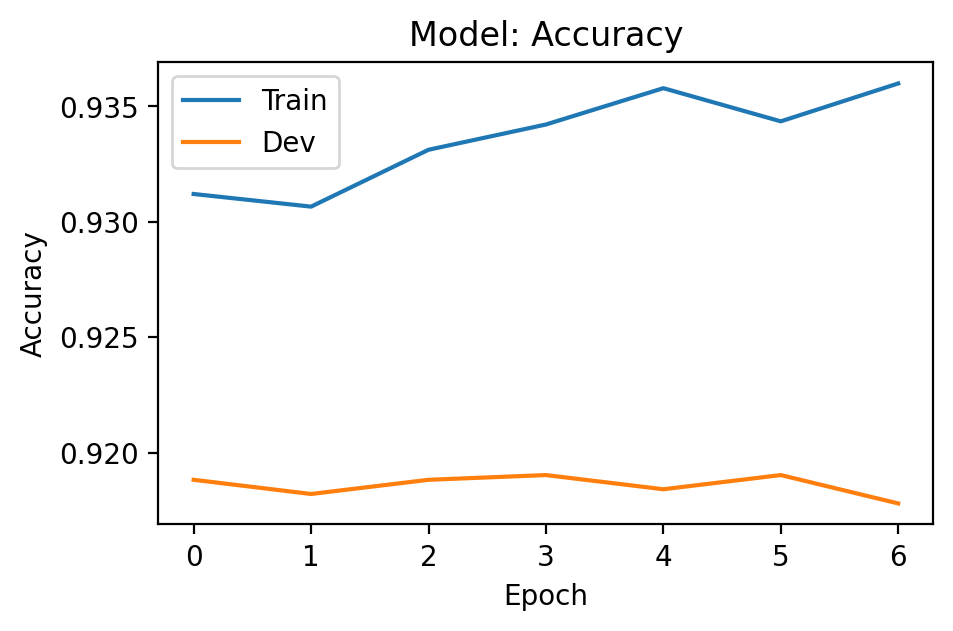

In [12]:
print(history.history.keys())
print(len(history.history['accuracy']))

fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Model: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ticklabel_format(useOffset=False)
plt.legend(['Train', 'Dev'], loc='upper left')

plt.savefig('Figs/casey_accuracy_plot.png')
plt.show()


---

Evaluate the model on the test set



In [13]:
loss, accuracy = best_model.evaluate(Xtest, ytest, batch_size=4096)
print("Accuracy: ", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9196 - loss: 0.2415
Accuracy:  0.9200164079666138


---

Predicting the first 10 observations


In [14]:

predictions = best_model.predict(Xtest[:10])
actual = np.asarray(ytest[:10].squeeze())
predictions = predictions.squeeze()
binary_pred = (predictions >= 0.5).astype(int)

df = pd.DataFrame({
    "actual": actual,
    "predictions":binary_pred
})


print(f"Accuracy: {accuracy}%")
print(df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Accuracy: 0.9200164079666138%
   actual  predictions
0       0            0
1       0            0
2       0            0
3       0            0
4       0            0
5       1            1
6       1            0
7       1            1
8       0            0
9       0            0
